In [ ]:
#
# Robustness to constant shift in Fig. 5
#

!pip uninstall lime -y
!pip install git+https://github.com/palatos/lime@ColorExperiments

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input

from lime import lime_image

from skimage.segmentation import mark_boundaries

In [76]:
filename = "/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches_fix.hdf5"
f = h5py.File(filename,'r')

f['pannuke/fold1/301/tumor'].keys()
im = f['pannuke/fold1/301/tumor/center/patch'][0]
mask = f['pannuke/fold1/301/tumor/center/mask'][0]

In [40]:
model = tf.keras.models.load_model('/mnt/nas2/results/IntermediateResults/Mara/MELBA/baseline_def_1/best_model.h5', compile=False)
model.layers[-1].activation = tf.keras.activations.sigmoid
model.compile()

In [41]:
#We don't directly use the base model because we want to be sure we are perturbing the images before preprocessing them.
#Otherwise covering the superpixels in 0 might not mean covering them in black.
#Best way to control this is to just define a wrapper-like class around the model, that includes the preprocessing in it.
#I'm also converting the sigmoid output to softmax-like because that's generally easier to handle and debug in LIME.
#GradCAM doesn't care about any of this so we can just use the model directly.

class MyModel():
    def __init__(self,model):
        self.model = model
        self.input_shape = model.input_shape
        self.output_shape = model.output_shape
        
    def predict(self, batch_images):
        
        #Image must be preprocessed before passed to LIME.
        batch_images = preprocess_input(batch_images.copy()) 
        
        sigm = self.model.predict(batch_images)
        
        softm = np.hstack((1-sigm,sigm))
        
        return softm


model_with_preprocessing = MyModel(model)

In [163]:
def plot_all(im, add, heatmap, sharpheatmap, shift_heatmap, shift_sharpheatmap):
    plt.rcParams['figure.figsize']=(20,10)
    plt.subplot(1,7,1)
    #mark=im
    #mark = mark_boundaries(mark,mask[:,:,i].astype('uint8'),mode='outer',outline_color=mark_colors[i])
    plt.imshow(im.astype('uint8'))
    plt.title('original')
    plt.axis("off")
    plt.subplot(1,7,2)
    plt.imshow((add+(add==0)*255).astype('uint8'))
    plt.title('shift')
    plt.axis('off')
    plt.subplot(1,7,3)
    plt.imshow(im.astype('uint8')+add.astype('uint8'))
    plt.title('modified')
    plt.axis('off')
    plt.subplot(1,7,4)
    plt.imshow(heatmap, cmap = 'RdBu', vmin=-sharpheatmap.max(), vmax = sharpheatmap.max())
    plt.title('original LIME')
    plt.axis('off')
    plt.subplot(1,7,6)
    imm=plt.imshow(sharpheatmap, cmap = 'RdBu', vmin=-sharpheatmap.max(), vmax = sharpheatmap.max())
    plt.title('original sharp-LIME')
    plt.axis('off')
    plt.subplot(1,7,5)
    plt.imshow(shift_heatmap, cmap = 'RdBu', vmin=-shift_sharpheatmap.max(), vmax = shift_sharpheatmap.max())
    plt.title('modified LIME')
    plt.axis("off")
    plt.subplot(1,7,7)
    #plt.figure(facecolor='white')
    imm=plt.imshow(shift_sharpheatmap, cmap = 'RdBu', vmin=-shift_sharpheatmap.max(), vmax = shift_sharpheatmap.max())
    plt.title('modified sharp-LIME')
    plt.axis('off')
    plt.colorbar(imm,fraction=0.045)#,cax=cax)

In [185]:
def get_orig_shifted_rank(im, mask, id_im=0,threshold=0.2, plot=False):
    np.random.seed(42)
    #Generate Squares
    squares = np.zeros(im.shape[:2])
    counter = 0
    for hor in range(3):
        for ver in range(3):
            squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
            counter+=1

    #Renumber segments, because they are numbered arbitrarily in the mask files.
    segments = np.sum(mask[:,:,0:5],axis=2).copy()

    temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

    renumbering_map = dict(zip(np.unique(segments),temp_renumber))

    segments = np.vectorize(renumbering_map.get)(segments)
    segments = np.where(segments.copy()==8,squares,segments)

    #LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
    def segfunc(im):
        return segments

    #Mark the nuclei
    mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
    mark = im.copy()/255

    for i in range(5):
        mark = mark_boundaries(mark,mask[:,:,i].astype('uint8'),mode='outer',outline_color=mark_colors[i])
    dim=im.shape
    add=np.zeros(dim)
    def get_random_segment():
        return np.random.randint(0,8)
    add[:,:,0]=(segments==get_random_segment())*np.random.randint(1,30)
    add[:,:,1]=(segments==get_random_segment())*np.random.randint(1,30)
    add[:,:,2]=(segments==get_random_segment())*np.random.randint(1,30)
    shifted_im=im+add
    #Generate LIME explanation for class 1
    explainer = lime_image.LimeImageExplainer()
    class_idx=1
    explanation_genetic = explainer.explain_instance(im.copy(), 
                                                     model_with_preprocessing.predict, 
                                                     segmentation_fn = None,# segfunc, 
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=200,
                                                     progress_bar=False)
    dict_genetic = dict(explanation_genetic.local_exp[class_idx])
    heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
    LIMEorig_rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)
    #Generate LIME explanation for class 1
    #explainer = lime_image.LimeImageExplainer()
    class_idx=1
    explanation_genetic = explainer.explain_instance(im.copy(), 
                                                     model_with_preprocessing.predict, 
                                                     segmentation_fn = segfunc, 
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=200,
                                                     progress_bar=False)
    dict_genetic = dict(explanation_genetic.local_exp[class_idx])
    sharpheatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
    sLIMEorig_rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)
    #Generate LIME explanation for class 1
    #explainer = lime_image.LimeImageExplainer()
    class_idx=1
    explanation_genetic = explainer.explain_instance(shifted_im.copy(), 
                                                     model_with_preprocessing.predict, 
                                                     segmentation_fn = None,# segfunc, 
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=200,
                                                     progress_bar=False)
    dict_genetic = dict(explanation_genetic.local_exp[class_idx])
    shift_heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
    LIMEshift_rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)
    #Generate LIME explanation for class 1
    #explainer = lime_image.LimeImageExplainer()
    class_idx=1
    explanation_genetic = explainer.explain_instance(shifted_im.copy(), 
                                                     model_with_preprocessing.predict, 
                                                     segmentation_fn = segfunc, 
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=200,
                                                     progress_bar=False)
    dict_genetic = dict(explanation_genetic.local_exp[class_idx])
    shift_sharpheatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
    sLIMEshift_rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)
    difference_pred = np.max(model_with_preprocessing.predict(np.expand_dims(im, axis=0)))-np.max(model_with_preprocessing.predict(np.expand_dims(shifted_im, axis=0)))
    if np.abs(difference_pred)>threshold:
        print("not used {}, diff: {}".format(id_img, difference_pred))
        pass
    if plot:
        plot_all(im, add, heatmap, sharpheatmap, shift_heatmap, shift_sharpheatmap)
    return LIMEshift_rank, LIMEorig_rank, sLIMEshift_rank, sLIMEorig_rank

In [186]:
keys=['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '1679', '168', '1680', '1681', '1682', '1683', '1684', '1685', '1686', '1687', '1688', '1689', '169', '1690', '1691', '1692', '1693', '1694', '1695', '1696', '1697', '1698', '1699', '17', '170', '1700', '1701', '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '171', '1710', '1711', '1712', '1713', '1714', '1715', '1716', '1717', '1718', '1719', '172', '1720', '1721', '1722', '1723', '1724', '1725', '1726', '1727', '1728', '1729', '173', '1730', '1731', '1732', '1733', '1734', '1735', '1736', '1737', '1738', '1739', '174', '1740', '1741', '1742', '1743', '1744', '1745', '1746', '1747', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '23', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '24', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '25', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '26', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '27', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '28', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '29', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '3', '30', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '31', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '32', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '33', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '34', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '35', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '36', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '37', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '38', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '39', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '4', '40', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '41', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '42', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '43', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '44', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '45', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '46', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '47', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '48', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '49', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '5', '50', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '51', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '52', '520', '521', '522', '523', '524', '525', '526', '527', '528', '529', '53', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '54', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '55', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '56', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '57', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579', '58', '580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '59', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '6', '60', '600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '61', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '62', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '63', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '64', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '65', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '66', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '67', '670', '671', '672', '673', '674', '675', '676', '677', '678', '679', '68', '680', '681', '682', '683', '684', '685', '686', '687', '688', '689', '69', '690', '691', '692', '693', '694', '695', '696', '697', '698', '699', '7', '70', '700', '701', '702', '703', '704', '705', '706', '707', '708', '709', '71', '710', '711', '712', '713', '714', '715', '716', '717', '718', '719', '72', '720', '721', '722', '723', '724', '725', '726', '727', '728', '729', '73', '730', '731', '732', '733', '734', '735', '736', '737', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '897', '898', '899', '9', '90', '900', '901', '902', '903', '904', '905', '906', '907', '908', '91', '92', '924', '925', '926', '927', '928', '929', '93', '930', '931', '94', '95', '96', '97', '98', '99']

In [194]:
limes=[]
slimes=[]
for k in keys[:400]:
#f['pannuke/fold1/301/tumor'].keys()
    try:
        im = f['pannuke/fold1/{}/tumor/center/patch'.format(k)][0]
        mask = f['pannuke/fold1/{}/tumor/center/mask'.format(k)][0]
    except:
        pass
    LIMEshift_rank, LIMEorig_rank, sLIMEshift_rank, sLIMEorig_rank = get_orig_shifted_rank(im, mask, id_im=0,threshold=0.2)#, plot=True)
    upto=min(len(LIMEshift_rank), len(LIMEorig_rank))
    lime_r,p=scipy.stats.spearmanr(LIMEorig_rank[:upto], LIMEshift_rank[:upto])
    slime_r,p=scipy.stats.spearmanr(sLIMEorig_rank, sLIMEshift_rank)
    limes.append(lime_r)
    slimes.append(slime_r)

In [ ]:
limes

Text(0, 0.5, 'SRCC')

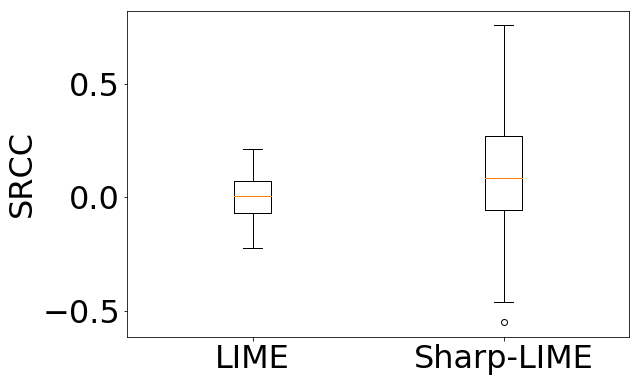

In [201]:
plt.rcParams['figure.figsize']=(9,6)
plt.rcParams['font.size']=32
plt.rcParams['lines.linewidth']=5
plt.boxplot([limes,slimes], positions=np.arange(2))
plt.xticks([0,1], ["LIME", "Sharp-LIME"])
plt.ylabel("SRCC")

In [200]:
import scipy.stats
scipy.stats.ttest_rel(limes,slimes)

Ttest_relResult(statistic=-9.470637667126447, pvalue=2.4889698435221874e-19)

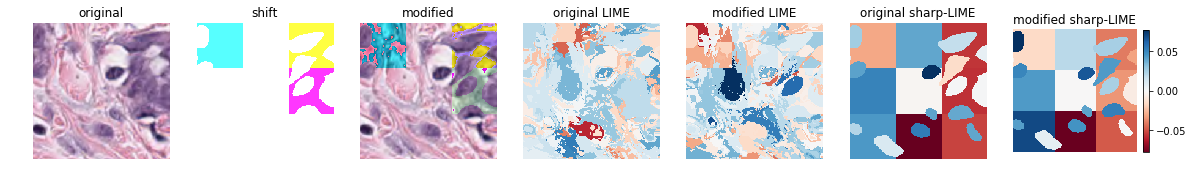